In [388]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import random

### References

- [Agglomerative Hierarchical Clustering in Python with Scikit-Learn](https://stackabuse.com/bytes/agglomerative-hierarchical-clustering-with-scikit-learn/)
- [K-Means Clustering in Python: A Practical Guide](https://realpython.com/k-means-clustering-python/#hierarchical-clustering)
- [Hierarchical Clustering](https://realpython.com/k-means-clustering-python/#hierarchical-clustering)
- [Definitive Guide to Hierarchical Clustering with Python and Scikit-Learn](https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/)
- [Hierarchical Agglomerative Clustering Algorithm Example In Python](https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019)

In [389]:
df_covid = pd.read_csv('../dataset/datacovid.csv')
df_covid

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


In [390]:
# creating a new cloumn based on the column 'DATE_DIED'
# DATE is e.g. 15/02/2020 - True(Died), otherwise is False(Alive).
df_covid['ALIVE_OR_DIED'] = np.where(df_covid['DATE_DIED']!= '9999-99-99', '0', '1')
df_covid['ALIVE_OR_DIED']

0          0
1          0
2          0
3          0
4          0
          ..
1048570    1
1048571    1
1048572    1
1048573    1
1048574    1
Name: ALIVE_OR_DIED, Length: 1048575, dtype: object

In [391]:
df_covid = df_covid.drop(columns='DATE_DIED') # drop column - DATE_DIED

In [392]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   INTUBED               1048575 non-null  int64 
 5   PNEUMONIA             1048575 non-null  int64 
 6   AGE                   1048575 non-null  int64 
 7   PREGNANT              1048575 non-null  int64 
 8   DIABETES              1048575 non-null  int64 
 9   COPD                  1048575 non-null  int64 
 10  ASTHMA                1048575 non-null  int64 
 11  INMSUPR               1048575 non-null  int64 
 12  HIPERTENSION          1048575 non-null  int64 
 13  OTHER_DISEASE         1048575 non-null  int64 
 14  CARDIOVASCULAR        1048575 non-null  int64 
 15

In [393]:
df_covid.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA',
       'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU',
       'ALIVE_OR_DIED'],
      dtype='object')

In [394]:
col_names = list(df_covid.columns)
col_names

['USMER',
 'MEDICAL_UNIT',
 'SEX',
 'PATIENT_TYPE',
 'INTUBED',
 'PNEUMONIA',
 'AGE',
 'PREGNANT',
 'DIABETES',
 'COPD',
 'ASTHMA',
 'INMSUPR',
 'HIPERTENSION',
 'OTHER_DISEASE',
 'CARDIOVASCULAR',
 'OBESITY',
 'RENAL_CHRONIC',
 'TOBACCO',
 'CLASIFFICATION_FINAL',
 'ICU',
 'ALIVE_OR_DIED']

In [395]:
columns = list()

items = random.randint(5, 10)
items

icount = 0
for col_name in col_names:
    if icount != items: 
        columns.append(col_name)
    else:
        break
    
    icount += 1
    
columns

['USMER',
 'MEDICAL_UNIT',
 'SEX',
 'PATIENT_TYPE',
 'INTUBED',
 'PNEUMONIA',
 'AGE',
 'PREGNANT']

In [396]:
first = columns[0]
last = columns[-1]

first_index = columns.index(first)
last_index = columns.index(last)

print(f'first element: {first} and last element: {last}')
print(f'first index: {first_index} and last index: {last_index}')

first element: USMER and last element: PREGNANT
first index: 0 and last index: 7


In [397]:
df_covid_reduced = df_covid.head(1000)

X = df_covid_reduced[columns].iloc[:, [first_index,last_index]].values

In [398]:
clusters = hierarchy.linkage(X, method="ward")

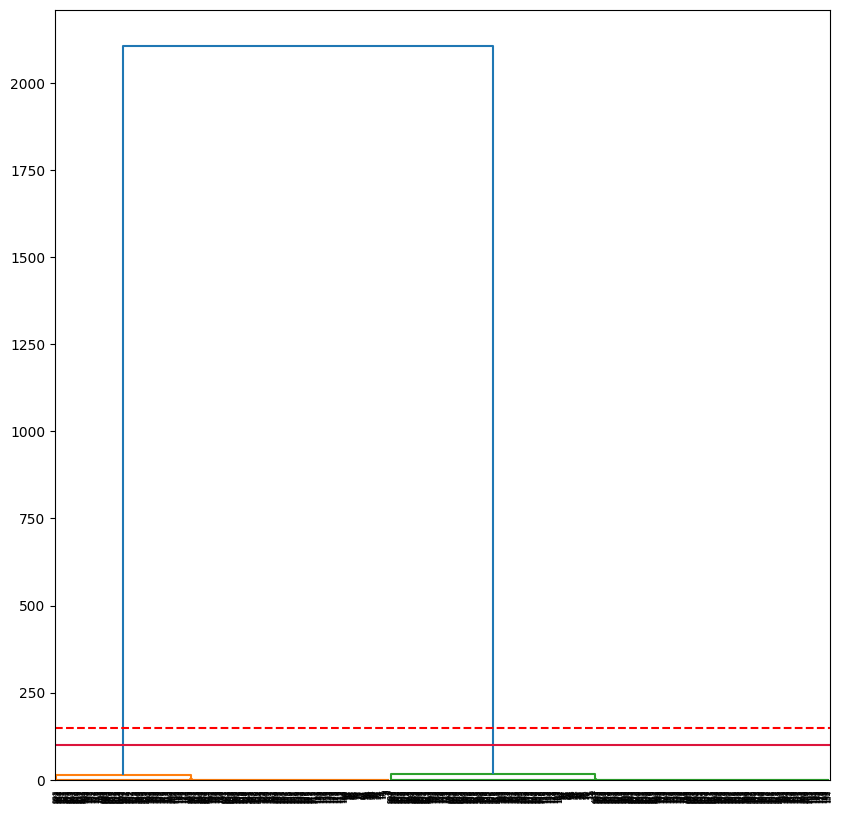

In [399]:
plt.figure(figsize=(10, 10))
dendrogram = hierarchy.dendrogram(clusters)
# Plotting a horizontal line based on the first biggest distance between clusters 
plt.axhline(150, color='red', linestyle='--'); 
# Plotting a horizontal line based on the second biggest distance between clusters 
plt.axhline(100, color='crimson')